<a href="https://colab.research.google.com/github/FabianWalocha/sentimentAnalysis/blob/master/TM_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CNN-LSTM approach

In [0]:
X, y  = [], []
with open("tweet_data_pre_processed.txt",'r') as f:
  for line in f:
    s = line.split(' ')
    if s[0]=='positive':
      y.append([1,0,0])
    elif s[0]=='neutral':
      y.append([0,1,0])
    elif s[0]=='negative':
      y.append([0,0,1])
    else:
      raise Exception('Error in preprocessing')
    X.append(" ".join(s[1:]))

In [0]:
import re
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''
    
    text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+','<url>',text)
    text = re.sub(r'[:;xX8][\^-]?[)DPp]+','<happy>',text)
    text = re.sub(r'\^[\.\_-]?\^','<happy>',text)
    text = re.sub(r':\'?[-\^]?[\/(C]+','<sad>',text)
    text = re.sub(r'T[\._-]?T','<sad>',text)
    text = re.sub(r'-[\._-]?-','<sad>',text)
    text = re.sub(r'\b[oO][\.-_,]?[oO]\b','<surpsised>',text)
    text = re.sub(r'-[\._-]?-','<surprised>',text)
    text = re.sub(r':[\^-]?[oO]','<surprised>',text)
    text = re.sub(r'D:','<surprised>',text)
    
    text = re.sub(r"\\", "", text)
    text = re.sub(r"u002c", "", text)
    text = re.sub(r"u2019", "'", text)
    text = re.sub(r"\n", "",  text)
    text = re.sub(r"[-()]", "", text)
    text = re.sub(r"\.", " .", text)
    text = re.sub(r"\!", " !", text)
    text = re.sub(r"\?", " ?", text)
    text = re.sub(r"\,", " ,", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'s", " is", text)
    # text = re.sub(r"he's", "he is", text)
    # text = re.sub(r"she's", "she is", text)
    # text = re.sub(r"it's", "it is", text)
    # text = re.sub(r"that's", "that is", text)
    # text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"oh+", "oh", text)
    text = re.sub(r"ah+", "ah", text)
    text = re.sub(r"aa+","a", text)
    text = re.sub(r"soo+\b",'soo', text)
    text = re.sub(r"aint", "is not", text)
    text = re.sub(r"gonna", "going to", text)
    text = re.sub(r"ima", "i am going to", text)
    text = re.sub(r"\/\w+", "", text)
    return text



In [0]:
%tensorflow_version 1.x
import numpy as np
from keras.preprocessing import sequence
from collections import defaultdict

Xc = []
tweet_lengths = []
for line in X:
    cleaned = clean_text(line)
    Xc.append(cleaned)
    tweet_lengths.append(len(cleaned.split(" ")))
X = Xc

# inspired by https://github.com/saurabhrathor/InceptionModel_SentimentAnalysis/
vocabulary = dict()
count = defaultdict(int)
inverse_vocabulary = ['PADDING']
for text in X:
    text = text.split()
    for word in text:
        count[word]+=1
        if word not in vocabulary:
            vocabulary[word] = len(inverse_vocabulary)
            inverse_vocabulary.append(word)

max_len = 0
sequences = []
for text in X:
    text = text.split()
    text_sequence = []
    for word in text:
      # constraint given term frequency
        if count[word] >= 1:
            text_sequence.append(vocabulary[word])
            inverse_vocabulary.append(word)
    # save longest tweet length
    if len(text_sequence)>max_len:
      max_len=len(text_sequence)
    sequences.append(text_sequence)
print("most words in tweet: {}".format(max(tweet_lengths)))

    
print("%d unique tokens in the vocabulary" %len(vocabulary))

MAX_SEQUENCE_LENGTH = max_len
bodies_seq = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


most words in tweet: 60
50897 unique tokens in the vocabulary


In [0]:
from gensim.models import Word2Vec
w2v = Word2Vec([" ".join(X).split(" ")],size=200, window=2, min_count=1, workers=4)
# w2v.train(X, total_examples=w2v.corpus_count, epochs=30, report_delay=1)

bodies_seq = np.zeros([len(X),max(tweet_lengths),200])
for idx,tweet in enumerate(X):
  for idx2,word in enumerate(tweet.split(" ")):
    bodies_seq[idx,idx2,:] = w2v[word]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(np.array(bodies_seq), np.array(y), test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.1)

print('Train: {} examples'.format(len(y_train)))
print('Val: {} examples'.format(len(y_val)))
print('Test: {} examples'.format(len(y_test)))

Train: 45300 examples
Val: 4530 examples
Test: 504 examples


In [0]:
# inspired by https://github.com/mihirahlawat/Sentiment-Analysis
# BB_twtr at SemEval-2017 Task 4: Twitter Sentiment Analysis with CNNs and LSTMs

from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D, AveragePooling1D, Bidirectional, merge, concatenate, Input, Dropout, LSTM

def w2vmodel(embedding_size=200, max_words=200, y_dim=1, vocabulary_size=50,
          num_filters=200, filter_sizes=[3,4,5], pool_padding='valid', dropout=0.5):
    embed_input = Input(shape=(max_words,embedding_size))
    pooled_outputs = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='valid', activation='relu')(embed_input)
        conv = MaxPooling1D(pool_size=max_words-filter_sizes[i]+1)(conv)           
        pooled_outputs.append(conv)
    merge = concatenate(pooled_outputs)
    
    x = Dense(30, activation='relu')(merge)
    x = Dropout(dropout)(x)
    x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Flatten()(x)
    x = Dense(y_dim, activation='softmax')(x)

    model = Model(inputs=embed_input,outputs=x)

    # model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
    # print(model.summary())
    
    from keras.utils import plot_model
    plot_model(model, to_file='shared_input_layer.png')
    
    return model

In [0]:
# inspired by https://github.com/mihirahlawat/Sentiment-Analysis
# BB_twtr at SemEval-2017 Task 4: Twitter Sentiment Analysis with CNNs and LSTMs

from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D, AveragePooling1D, Bidirectional, merge, concatenate, Input, Dropout, LSTM

def model(embedding_size=200, max_words=200, y_dim=1, vocabulary_size=50,
          num_filters=200, filter_sizes=[3,4,5], pool_padding='valid', dropout=0.5):
    embed_input = Input(shape=(max_words,))
    x = Embedding(vocabulary_size, embedding_size, input_length=max_words)(embed_input)
    print(x)
    pooled_outputs = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='valid', activation='relu')(x)
        conv = MaxPooling1D(pool_size=max_words-filter_sizes[i]+1)(conv)           
        pooled_outputs.append(conv)
    merge = concatenate(pooled_outputs)
    
    x = Dense(30, activation='relu')(merge)
    x = Dropout(dropout)(x)
    x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Flatten()(x)
    x = Dense(y_dim, activation='softmax')(x)

    model = Model(inputs=embed_input,outputs=x)

    # model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
    # print(model.summary())
    
    from keras.utils import plot_model
    plot_model(model, to_file='shared_input_layer.png')
    
    return model

In [0]:
from keras import backend as K
import tensorflow as tf

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)
  

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np

from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

mdl = w2vmodel(embedding_size=200, max_words=MAX_SEQUENCE_LENGTH, vocabulary_size=len(vocabulary)+1,
            y_dim=y_train.shape[1],filter_sizes = [3,4,5],dropout=0.1)
mdl.compile(loss=f1_loss,#'categorical_crossentropy', 
            optimizer='adam', 
            metrics=['acc',f1_m,precision_m, recall_m])

batch_size = 32
num_epochs = 100

batch_size = 32
num_epochs = 200


earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('w2v_saved_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=0, epsilon=1e-4, mode='min')


history = mdl.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=num_epochs, 
          callbacks=[
                     #earlyStopping, 
                     mcp_save]
          )


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 45300 samples, validate on 4530 samples
Epoch 1/200
45300/45300 [==============================] - 34s 760us/step - loss: 0.6583 - acc: 0.4365 - f1_m: 0.2836 - precision_m: 0.4183 - recall_m: 0.2516 - val_loss: 0.6444 - val_acc: 0.4369 - val_f1_m: 0.4350 - val_precision_m: 0.4434 - val_recall_m: 0.4272
Epoch 2/200
45300/45300 [==============================] - 31s 693us/step - loss: 0.6112 - acc: 0.4297 - f1_m: 0.4184 - precision_m: 0.4429 - recall_m: 0.3985 - val_loss: 0.5937 - val_acc: 0.4272 - val_f1_m: 0.4234 - val_precision_m: 0.4300 - val_recall_m: 0.4172
Epoch 3/200
45300/45300 [==============================] - 32s 696us/step - loss: 0.5764 - acc: 0.4682 - f1_m: 0.4658 - precision_m: 0.4706 - recall_m: 0.4613 - val_loss: 0.5611 - val_acc: 0.4960 - val_f1_m: 0.4955 - val_precision_m: 0.4966 - val_recall_m: 0.4945
Epoch 4/200
45300/45300 [==============================] - 31s 691us/step - loss: 0.5539 - acc: 0.4933 - f1_m: 0.4923 - precision_m: 0.4942 - recall_m: 0.4905 

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'], linewidth=2)
# plt.plot(history.epoch,history.history['f1_m'],history.epoch,history.history['val_f1_m'])
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Training loss', 'Validation loss'], fontsize=15)
plt.show()

In [0]:
from keras.models import load_model

mdl = load_model('w2v_saved_model.h5', custom_objects={
                                                  'f1_loss':f1_loss, 
                                                  'f1_m':f1_m,
                                                  'precision_m':precision_m,
                                                  'recall_m':recall_m
                                                   })
loss, acc, f1, prec, rec = mdl.evaluate(X_test, y_test)
print("loss: {}, accuracy: {}, f1-score: {}, precision: {}, recall: {}".format(round(loss,4), round(acc,4), round(f1,4), round(prec,4), round(rec,4)))

504/504 [==============================] - 1s 2ms/step
loss: 0.4751, accuracy: 0.5893, f1-score: 0.5893, precision: 0.5893, recall: 0.5893


In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np

from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

mdl = model(embedding_size=100, max_words=MAX_SEQUENCE_LENGTH, vocabulary_size=len(vocabulary)+1,
            y_dim=y_train.shape[1],filter_sizes = [3,4,5],dropout=0.1)
mdl.compile(loss=f1_loss,#'categorical_crossentropy', 
            optimizer='adam', 
            metrics=['acc',f1_m,precision_m, recall_m])

batch_size = 32
num_epochs = 100


Tensor("embedding_6/embedding_lookup/Identity:0", shape=(?, 59, 100), dtype=float32)


In [0]:
batch_size = 32
num_epochs = 200


earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('saved_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=0, epsilon=1e-4, mode='min')


history = mdl.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=num_epochs, 
          callbacks=[
                     #earlyStopping, 
                     mcp_save]
          )

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 45300 samples, validate on 4530 samples
Epoch 1/200
45300/45300 [==============================] - 27s 586us/step - loss: 0.5015 - acc: 0.5608 - f1_m: 0.5300 - precision_m: 0.5585 - recall_m: 0.5210 - val_loss: 0.4473 - val_acc: 0.5954 - val_f1_m: 0.5954 - val_precision_m: 0.5954 - val_recall_m: 0.5954
Epoch 2/200
45300/45300 [==============================] - 22s 494us/step - loss: 0.4171 - acc: 0.6278 - f1_m: 0.6278 - precision_m: 0.6280 - recall_m: 0.6275 - val_loss: 0.4410 - val_acc: 0.6084 - val_f1_m: 0.6084 - val_precision_m: 0.6084 - val_recall_m: 0.6084
Epoch 3/200
45300/45300 [==============================] - 22s 491us/step - loss: 0.3979 - acc: 0.6440 - f1_m: 0.6440 - precision_m: 0.6442 - recall_m: 0.6438 - val_loss: 0.4416 - val_acc: 0.6046 - val_f1_m: 0.6046 - val_precision_m: 0.6046 - val_recall_m: 0.6046
Epoch 4/200
45300/45300 [==============================] - 22s 485us/step - loss: 0.3895 - acc: 0.6513 - f1_m: 0.6514 - precision_m: 0.6515 - recall_m: 0.6513 

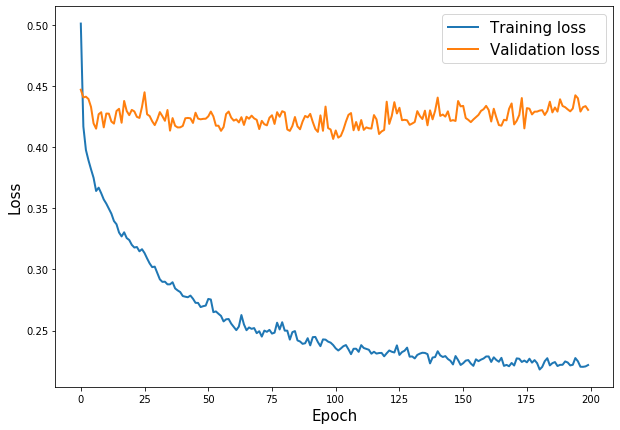

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'], linewidth=2)
# plt.plot(history.epoch,history.history['f1_m'],history.epoch,history.history['val_f1_m'])
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Training loss', 'Validation loss'], fontsize=15)
plt.show()

In [0]:
from keras.models import load_model

mdl = load_model('saved_model.h5', custom_objects={
                                                  'f1_loss':f1_loss, 
                                                  'f1_m':f1_m,
                                                  'precision_m':precision_m,
                                                  'recall_m':recall_m
                                                   })
loss, acc, f1, prec, rec = mdl.evaluate(X_test, y_test)
print("loss: {}, accuracy: {}, f1-score: {}, precision: {}, recall: {}".format(round(loss,4), round(acc,4), round(f1,4), round(prec,4), round(rec,4)))

504/504 [==============================] - 1s 3ms/step
loss: 0.3819, accuracy: 0.6448, f1-score: 0.6448, precision: 0.6448, recall: 0.6448


In [1]:
[1,2,3]+[4,5,6]

[1, 2, 3, 4, 5, 6]

In [2]:
a = {'a':[1]}

In [7]:
try:
    a['b']
except KeyError:
    print("hello")

hello


In [3]:
from w2vLSTM import score_CNN_LSTM as m2

In [4]:
m2([1],[0],[1],[0],[1],[0])

TypeError: sequence item 0: expected str instance, int found

In [9]:
from gensim.models import Word2Vec

X_train = ['asd sjanfk','asdsf kjasn','asfans aslknd']
wv = Word2Vec(" ".join(X_train).split(" ")+['<$>'])
[wv[word] for word in " ".join(X_train).split(" ")]

C:\Users\fwalo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


KeyError: "word 'asd' not in vocabulary"

In [6]:
X_train.append(['<$>'])
X_train

['asd', 'asdsf', 'asfans', ['<$>'], ['<$>'], ['<$>']]